# 1. Load the data

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [4]:
data_train_raw.shape

(188318, 132)

# 2. Data transformation

In [5]:
ylog=np.log1p(data_train_raw['loss'])
ymean=ylog.mean()
ystd=ylog.std()
# ymean=0
# ystd=1
data_train_raw['loss_g']=(ylog-ymean)/ystd

In [6]:
# clean outliers in training data
lossMean = data_train_raw['loss_g'].mean()
lossStd = data_train_raw['loss_g'].std()
print('Mean of log1py: {}'.format(lossMean))
print('Std of log1py: {}'.format(lossStd))
lbound = lossMean-3.0*lossStd
ubound = lossMean+3.0*lossStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw['loss_g']>=lbound) & (data_train_raw['loss_g']<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))

Mean of log1py: -1.13349409935e-13
Std of log1py: 1.0
Lower clipping bound: -3.0
Upper clipping bound: 3.0
Shape of cleaned data: (187954, 133)


In [7]:
def ToUniform(y):
    z = norm.cdf(-y/np.sqrt(2))
    return z
def UniformToGauss(z):
    return -np.sqrt(2)*norm.ppf(z)*ystd+ymean
# def BackToOriginal(z):
#     return np.exp(UniformToGauss(z))

data_train_raw['loss_u']=ToUniform(data_train_raw['loss_g'])

def lossRestore(logloss, ymean, ystd):
    loss = np.expm1(logloss*ystd+ymean)
    return loss

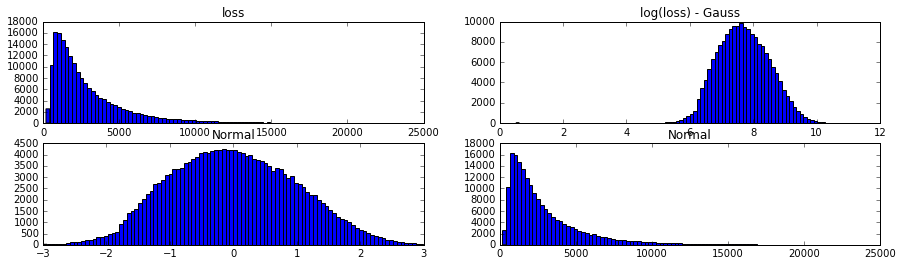

In [8]:
plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
plt.hist(data_train_raw['loss'],100)
plt.title('loss');

plt.subplot(2,2,2)
plt.hist(ylog,100)
plt.title('log(loss) - Gauss');

plt.subplot(2,2,3)
plt.hist(data_train_raw['loss_g'],100)
plt.title('Normal');

plt.subplot(2,2,4)
plt.hist(lossRestore(data_train_raw['loss_g'],ymean,ystd),100)
plt.title('Normal');

# 3. Data preparation

### labeling encoder

In [9]:
# save label in a seperate serie
labelSs = data_train_raw['loss_g'] 
trainDf = data_train_raw.drop(['id','loss','loss_g','loss_u'],axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has features from the raw data:\n{}'.format(trainDf.columns))
print('testDf has features from the raw data:\n{}'.format(testDf.columns))

trainDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [10]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313500, 130)
(313500, 116) of which are categorical
(313500, 14) of which are continuous


In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in dataCatAll.columns:
    if (col.find('cat') !=-1):
#        print(col)
        dataCatAll[col]=le.fit_transform(dataCatAll[col])
#         dataAll[col] = dataAll[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
#         le.classes_ = np.append(le.classes_, '<unknown>')
#         data_test_raw[str(col+'_numerical')]=le.transform(data_test_raw[col])
print(dataCatAll.columns)


/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cat107', u'cat108', u'cat109', u'cat110', u'cat111', u'cat112',
       u'cat113', u'cat114', u'cat115', u'cat116'],
      dtype='object', length=116)


### skipped - restore to x_trainDf and x_testDf

In [12]:
# # hstack all the features and .
# x_allDf = pd.concat([dataCatAll,dataFltAll],axis=1)
# x_means = x_allDf.mean()
# x_stds = x_allDf.std()
# x_allDf = (x_allDf-x_means)/x_stds
# x_allDf.head()

In [13]:
# x_Train = x_allDf.iloc[0:len(labelSs),:]
# x_Test = x_allDf.iloc[len(labelSs):,:]
# y_Train = labelSs

### one-hot-encoding

In [14]:
# one-hot-encoding the categorical features
enc = preprocessing.OneHotEncoder()
x_catAll = enc.fit_transform(dataCatAll)
print(x_catAll.shape)

(313500, 1175)


In [15]:
# split x_train and x_test
x_Train = sp.sparse.hstack((x_catAll[0:len(labelSs),:], sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_Test = sp.sparse.hstack((x_catAll[len(labelSs):,:], sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_Train = labelSs.values

### check the dimension of prepared data

In [16]:
print(x_Test.shape)
print(x_Train.shape)
print(y_Train.shape)

(125546, 1189)
(187954, 1189)
(187954,)


### split the training data for valication

In [17]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_Train, y_Train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(150363, 1189)
(150363,)
(37591, 1189)
(37591,)


In [18]:
del x_Train
del y_Train
# del x_catAll
# del dataCatAll
del trainDf
del testDf

# 4. 1st Level Model Fitting

In [19]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')
testList = ['Ridge', 'XGBoostTrees', 'AdaBoosting', 'MLPRegressor','Ensemble']

### Ridge Regression

In [20]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

In [21]:
cv = 3
# alphas = (1e-2,1e-1,1,1e1,1e2)
# alphas = (20,30,40)
alphas = [40]
regCV = RidgeCV(cv=cv,alphas = alphas)
regCV.fit(x_train,y_train)
print('alpha: {}\n'.format(regCV.alpha_))
# print('cv_values_: {}\n'.format(regCV.cv_values_))

alpha: 40



In [22]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV.predict(x_val),ymean,ystd)))

1229.07910667


In [23]:
y_pred_i = lossRestore(regCV.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(regCV.predict(x_val),ymean,ystd))

### skipped - Lasso Regression - almost the same as Ridge

In [24]:
# from sklearn.linear_model import LassoCV

In [25]:
# cv = 3
# # alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3)
# # alphas = (0.0005,0.0007,0.001,0.003,0.005)
# # alphas = [0.00005,0.0001,0.0003,0.0005]
# alphas = [0.00005]
# LassoCV = LassoCV(cv=cv,alphas = alphas)
# LassoCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(LassoCV.alpha_))

In [26]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(LassoCV.predict(x_val),ymean,ystd)))

In [27]:
# y_pred_i = lossRestore(LassoCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(LassoCV.predict(x_val),ymean,ystd))

### Skipped - Random Forest - using mse rather than mae, because the mae implementation is much slower.

In [28]:
# from sklearn.ensemble import RandomForestRegressor

In [29]:
# criterion = 'mse'
# n_estimators = [30]
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpRFReg = RandomForestRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
#     tmpRFReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpRFReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         RFReg = tmpRFReg
#         n_estimator = n_est
#         err = err_i

In [30]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(RFReg.predict(x_val),ymean,ystd)))

In [31]:
# y_pred_i = lossRestore(RFReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(RFReg.predict(x_val),ymean,ystd))

### XGBoost Trees

In [32]:
import xgboost as xgb

In [33]:
# x_train, x_val, y_train, y_val
# d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
# d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
# x_val_xgb = xgb.DMatrix(x_val.tocsc())
# d_test_xgb = xgb.DMatrix(x_Test.tocsc())
d_train_xgb = xgb.DMatrix(x_train,label=y_train)
d_val_xgb = xgb.DMatrix(x_val,label = y_val)
x_val_xgb = xgb.DMatrix(x_val)
d_test_xgb = xgb.DMatrix(x_Test)

In [34]:
num_round = 33
params = {'eval_metric':'rmse','max_depth':9}
watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist)

[0]	eval-rmse:0.93553	train-rmse:0.93455
[1]	eval-rmse:0.836579	train-rmse:0.83068
[2]	eval-rmse:0.773478	train-rmse:0.762768
[3]	eval-rmse:0.739286	train-rmse:0.724183
[4]	eval-rmse:0.71914	train-rmse:0.700578
[5]	eval-rmse:0.706075	train-rmse:0.684085
[6]	eval-rmse:0.697742	train-rmse:0.6726
[7]	eval-rmse:0.691603	train-rmse:0.663485
[8]	eval-rmse:0.686154	train-rmse:0.65549
[9]	eval-rmse:0.681842	train-rmse:0.649048
[10]	eval-rmse:0.678887	train-rmse:0.644115
[11]	eval-rmse:0.676401	train-rmse:0.63965
[12]	eval-rmse:0.674989	train-rmse:0.635801
[13]	eval-rmse:0.673654	train-rmse:0.63205
[14]	eval-rmse:0.672761	train-rmse:0.62923
[15]	eval-rmse:0.671775	train-rmse:0.626138
[16]	eval-rmse:0.670469	train-rmse:0.623286
[17]	eval-rmse:0.669827	train-rmse:0.620435
[18]	eval-rmse:0.669061	train-rmse:0.617768
[19]	eval-rmse:0.668662	train-rmse:0.616328
[20]	eval-rmse:0.66817	train-rmse:0.614652
[21]	eval-rmse:0.667852	train-rmse:0.612606
[22]	eval-rmse:0.667415	train-rmse:0.610553
[23]	eval

In [35]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))

1157.59425957


In [36]:
y_pred_i = lossRestore(gbt.predict(d_test_xgb),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))

### AdaBoost Regression

In [37]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

In [38]:
# n_estimators = [30, 60, 90, 120]
# n_estimators = [10,20,30,40]
n_estimators = [6]
base_estimator = Ridge(alpha = 40)
err = 999999999
n_estimator = 0
random_state = 0
for n_est in n_estimators:
    tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state,base_estimator = base_estimator)
#     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state)
    tmpAdReg.fit(x_train,y_train)
    err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpAdReg.predict(x_val),ymean,ystd))
    print(err_i)
    if err_i < err:
        AdReg = tmpAdReg
        n_estimator = n_est
        err = err_i

1230.15703558


In [39]:
print('n_estimator = {}'.format(n_estimator))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(AdReg.predict(x_val),ymean,ystd)))

n_estimator = 6
1230.15703558


In [40]:
y_pred_i = lossRestore(AdReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(AdReg.predict(x_val),ymean,ystd))

### Skipped - K Nearest Neighbors

In [41]:
# from sklearn.neighbors import KNeighborsRegressor

In [42]:
# n_neighbors = [5, 10, 15]
# weights = 'distance'
# err = 999999999
# n_nns = 0
# # random_state = 0
# for n_nn in n_neighbors:
#     tmpKNReg = KNeighborsRegressor(n_neighbors = n_nn,weights = weights)
#     tmpKNReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpKNReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         KNReg = tmpKNReg
#         n_nns = n_nn
#         err = err_i

In [43]:
# print('n_neighbors = {}'.format(n_nns))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(KNReg.predict(x_val),ymean,ystd)))

In [44]:
# y_pred_i = lossRestore(KNReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(KNReg.predict(x_val),ymean,ystd))

### skipped - Linear SVR - similar to the Ridge results

In [45]:
# from sklearn.svm import LinearSVR,SVR

In [46]:
## SVReg = SVR(kernel = 'rbf')
## SVReg.fit(x_train,y_train)
#SVReg = LinearSVR(C=0.5)
#SVReg.fit(x_train,y_train)

In [47]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(SVReg.predict(x_val),ymean,ystd)))

In [48]:
# y_pred_i = lossRestore(SVReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(SVReg.predict(x_val),ymean,ystd))

### MLP Regressor

In [49]:
from sklearn.neural_network import MLPRegressor

In [50]:
MLPReg = MLPRegressor(alpha = 1e-5, hidden_layer_sizes = (35,3),random_state=0,early_stopping=True)
MLPReg.fit(x_train,y_train)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(35, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [51]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(MLPReg.predict(x_val),ymean,ystd)))

1150.14015193


In [52]:
y_pred_i = lossRestore(MLPReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(MLPReg.predict(x_val),ymean,ystd))

### Averaging results to get the ensemble

In [53]:
# ensemble the results
y_pred.append(np.ndarray.mean(np.vstack(y_pred).T,axis=1))

# ensembled y_val
print('The loss of the ensembled result:')
y_pred_val_en = np.ndarray.mean(np.vstack(y_pred_val).T,axis=1)
mean_absolute_error(lossRestore(y_val,ymean,ystd),y_pred_val_en)

The loss of the ensembled result:


1158.4874281952289

In [54]:
y_pred_val.append(y_pred_val_en)
# testList.append('y_val')
# testList

# 5. Check the correlation among results of different models

### correlation among all the predicted resutls for the validation set

In [55]:
# testList.append('y_val')
yValPredDf = pd.DataFrame(data=np.column_stack(y_pred_val), columns = testList )

yValPredDf = yValPredDf.applymap(lambda x: (np.log1p(x)-ymean)/ystd)
yValPredDf['y_val'] = y_val
yValPredDf.head()

,Ridge,XGBoostTrees,AdaBoosting,MLPRegressor,Ensemble,y_val
0,-0.540942,-0.697255,-0.601364,-0.690997,-0.630910,-1.405770
1,0.183776,0.266266,0.195486,0.203166,0.212592,0.241794
2,-0.216731,-0.105640,-0.218522,-0.099010,-0.158625,-1.104847
3,-0.684679,-0.772107,-0.724856,-0.690632,-0.717581,-0.882158
4,1.161698,1.075962,1.107666,0.910433,1.067434,0.914716


In [56]:
# (np.log1p(y_pred_val[5])-ymean)/ystd

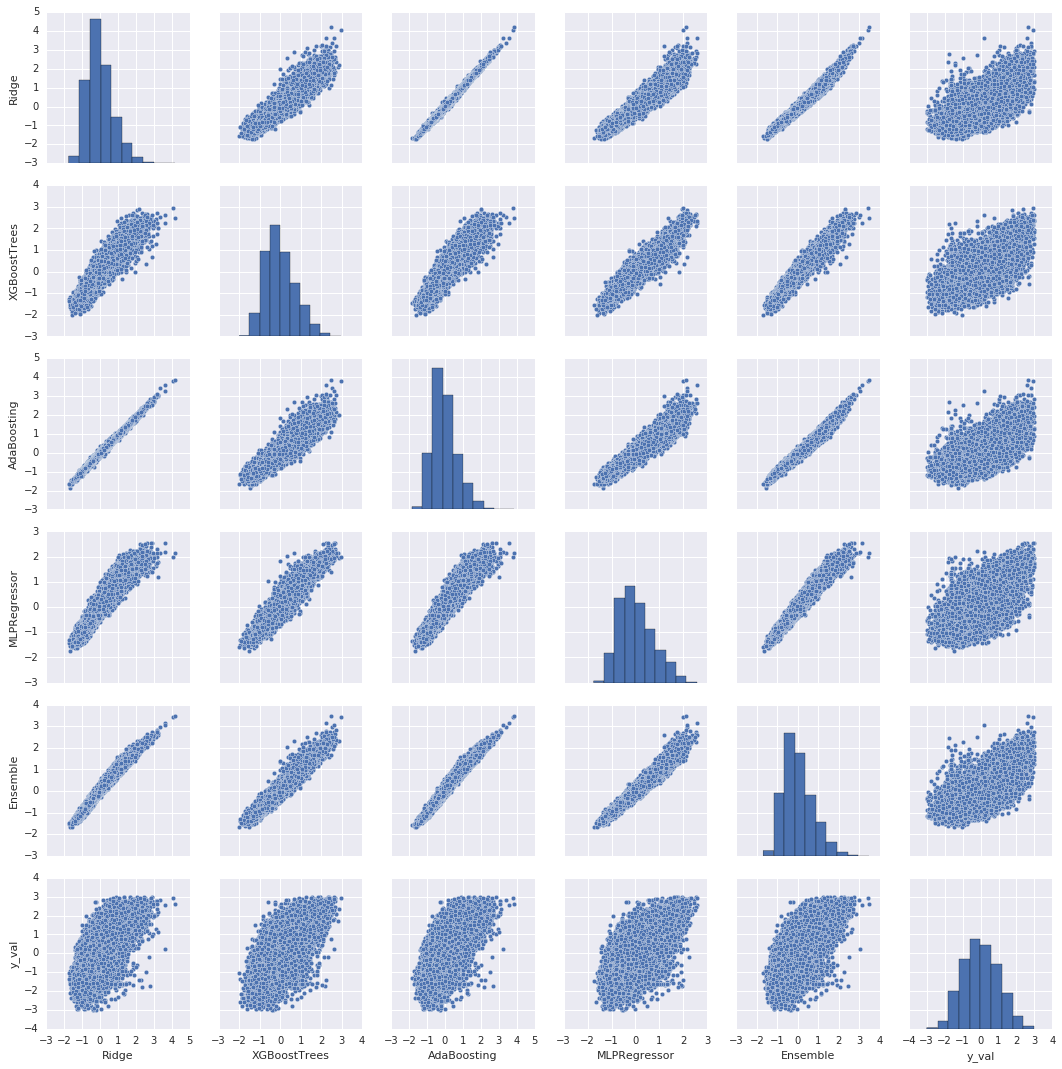

In [57]:
import seaborn as sns
sns.pairplot(yValPredDf);

### generate new features from the intermediate results of level 1

In [63]:
x_train_1 = np.column_stack([regCV.predict(x_train), gbt.predict(d_train_xgb), AdReg.predict(x_train), MLPReg.predict(x_train)])

x_val_1 = np.column_stack(y_pred_val[0:4])
x_val_1 = (np.log1p(x_val_1)-ymean)/ystd

x_test_1 = np.column_stack(y_pred[0:4])
x_test_1 = (np.log1p(x_test_1)-ymean)/ystd

In [64]:
print(x_train_1.shape)
print(x_val_1.shape)
print(x_test_1.shape)

(150363, 4)
(37591, 4)
(125546, 4)


In [65]:
# x_train_1
# x_val_1
# x_test_1

# 6. 2nd Level Model Fitting

### Ridge

In [66]:
cv = 5
alphas = [1e-3,1e-2,1e-1,1,1e1,1e2,1e3]
# alphas = (20,30,40)
# alphas = [40]
regCV_2 = RidgeCV(cv=cv,alphas = alphas)
regCV_2.fit(x_train_1,y_train)
print('alpha: {}\n'.format(regCV_2.alpha_))
# print('cv_values_: {}\n'.format(regCV_2.cv_values_))

alpha: 1



In [67]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV_2.predict(x_val_1),ymean,ystd)))

1187.91898871


In [68]:
y_pred_i = lossRestore(regCV_2.predict(x_test_1),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(regCV_2.predict(x_val_1),ymean,ystd))

### XGBoost

In [69]:
d_train_xgb_1 = xgb.DMatrix(x_train_1,label=y_train)
d_val_xgb_1 = xgb.DMatrix(x_val_1,label = y_val)
x_val_xgb_1 = xgb.DMatrix(x_val_1)
d_test_xgb_1 = xgb.DMatrix(x_test_1)

In [70]:
num_round = 8
params = {'eval_metric':'rmse','max_depth':9}
watchlist  = [(d_val_xgb_1,'eval'), (d_train_xgb_1,'train')]
gbt_1 = xgb.train(params, d_train_xgb_1,num_round,watchlist)

[0]	eval-rmse:0.90155	train-rmse:0.881547
[1]	eval-rmse:0.787406	train-rmse:0.744478
[2]	eval-rmse:0.728023	train-rmse:0.666034
[3]	eval-rmse:0.699288	train-rmse:0.623115
[4]	eval-rmse:0.686054	train-rmse:0.600181
[5]	eval-rmse:0.681029	train-rmse:0.587649
[6]	eval-rmse:0.67951	train-rmse:0.580862
[7]	eval-rmse:0.679302	train-rmse:0.576971


In [71]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt_1.predict(x_val_xgb_1),ymean,ystd)))

1179.14753297


In [ ]:
y_pred_i = lossRestore(gbt_1.predict(d_test_xgb_1),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(gbt_1.predict(x_val_xgb_1),ymean,ystd))

# 7. Save results and the trained model

In [ ]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [ ]:
from sklearn.externals import joblib
joblib.dump([regCV, gbt, AdReg, MLPReg, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_Test]
            ,'../output/models_data_on_raw_features.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 